# Pay Attention to MLPs

**Executing the concepts outlined in the paper ["Pay Attention to MLPs"](https://arxiv.org/pdf/2105.08050v1.pdf).**

## Introduction

In our project, we followed the guidelines presented in the research paper titled "Pay Attention to MLPs" and applied the neural network structure detailed in the paper to classify image datasets.

Once our implementation proved successful, we conducted experiments with the CIFAR10 dataset, consisting of 60,000 labeled color images sized 32x32 pixels, categorized into 10 classes (e.g., dog, bird, airplane). To enhance our results, we experimented with different parameter tuning approaches.

To start, we will provide a brief overview of the implemented architecture and its associated advantages.

## Overview of gMLP Architecture

The paper introduces an architecture named gMLP, designed for vision applications and Natural Language Processing (NLP). It stands out by excluding self-attention modules, providing an alternative perspective for Transformers. The gMLP model primarily relies on basic Multi-Layer Perceptron (MLP) layers and incorporates a gating mechanism.

Let's delve into a summary of how the model operates. The overall structure of the architecture is visually represented in the accompanying image.

<div>
<img src="gMLP.png" width="500"/>
</div>

1. **Input Embedding:** The initial step involves transforming the input into a tensor suitable for the network, ensuring the output tensor has a channel dimension of d_model.
2. **gMLP Blocks:** Lx gMLP blocks follow, connected in series, each with its trainable parameters. These blocks encompass the following steps:
    * Creating a copy of the input and storing it separately.
    * Passing the input through a Normalization layer (Layer Normalization).
    * Channel Projection layer over the channel axis with a Fully Connected Linear Layer having d_ffn output nodes.
    * Applying Gaussian Error Linear Unit Activation.
    * Feeding the output into the Spatial Gating Unit.
        * Splitting the input into two parts along the channel axis (u and v)
        * Normalizing v
        * Projecting v spatially
        * Element-wise multiplying it with u
    * Passing through another Projection layer over the channel axis.
    * Adding the shortcut to the output for better training of identity mappings.
3. **Model Training:** The authors trained the gMLP architecture on the ImageNet dataset and for BERT Masked Language Modeling. For the ImageNet task, three versions of the network were proposed with varying parameters (Lx, d_model, d_ffn, dropout probability), achieving the following accuracies:
    * gMLP-Ti: 72%
    * gMLP-S: 79.4%
    * gMLP-B: 81.6%
    
These results compare favorably with other architectures, demonstrating the effectiveness of the gMLP model.
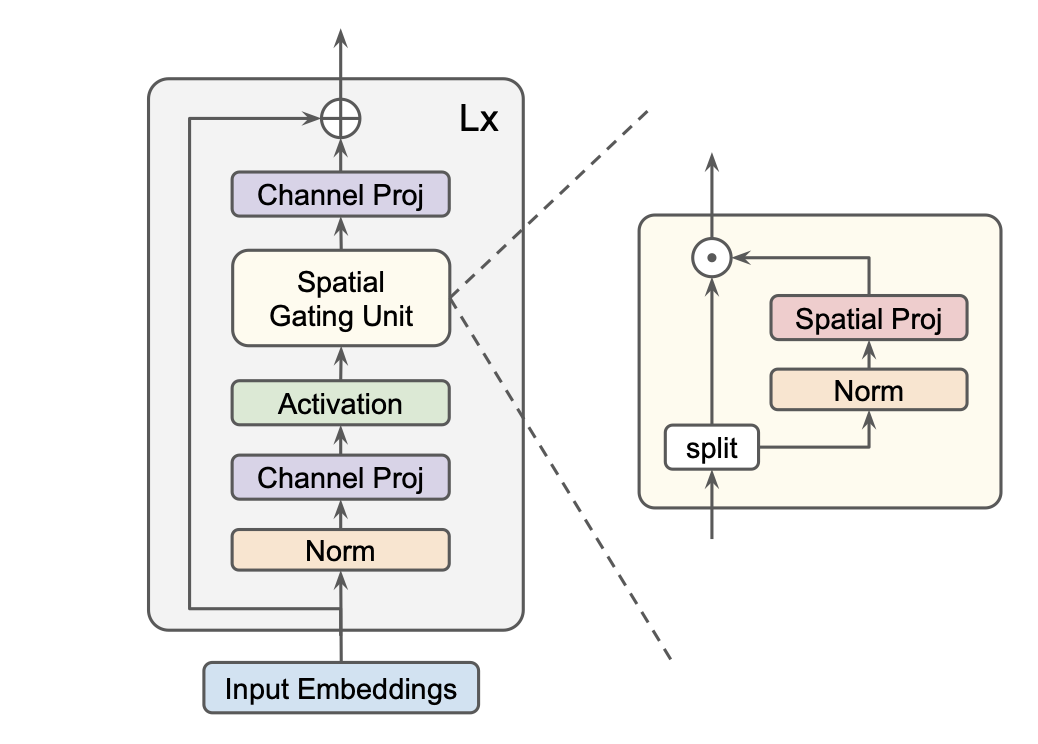

## Overview of our Implementation

Our implementation is organized into distinct sections:

1. **Implementation of gMLP:** This includes module definitions for the key components of gMLP and our adaptation for image classification. Noteworthy modules are SpatialGatingUNIT, gMLPBlock, gMLP, and gMLPImage.
2. **Supporting Methods:** These methods play a role in various evaluations. Notable functions include "evaluate_model" and "get_accuracy".
3. **Training Methods:** Responsible for training our models, these methods are encapsulated in "loop_vm".
4. Sections for Training Different Datasets: These sections are further divided into the following subsections:
    * Set Parameters
    * Import Dataset and Preparation of DataLoaders
    * Create the Model with Given Parameters and Move It to Device
    * Train the Models on the Dataset
    * Evaluate the Model and Obtain the Confusion Matrix

In our code, crucial aspects are elucidated through comments. Model evaluation occurs both during training with a validation dataset and after the network has been trained with a test dataset. The outputs include accuracy, precision, recall, and a confusion matrix. The subsequent sections will delve into the actual code segments.

## Import necessary libraries

In [39]:
import torch.nn as nn
import torch
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import tqdm
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

## Setting the Device

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Implementation of gMLP

In [26]:
# Definition of the Spatial Gating Unit class
class SpatialGatingUnit(nn.Module):
    def __init__(self, d_ffn, seq_len):
        super(SpatialGatingUnit, self).__init__()

        # Layer normalization for the second part of the input
        self.norm = nn.LayerNorm(d_ffn // 2)
        
        # Linear projection for the spatial gating
        self.proj = nn.Linear(seq_len, seq_len)
        
        # Initialize weights close to zero and biases as one
        nn.init.uniform_(self.proj.weight, -0.01, 0.01)
        nn.init.ones_(self.proj.bias)

    def forward(self, x):
        # Split input x into two equal parts, u and v, along the channel axis
        u, v = x.chunk(2, dim=-1)
        
        # Perform layer normalization on v
        v = self.norm(v)
        
        # Change the channel with the spatial dimension for v
        v = v.permute(0, 2, 1)
        
        # Perform spatial projection
        v = self.proj(v)
        
        # Change the channel with the spatial dimension back to normal
        v = v.permute(0, 2, 1)
        
        # Return the product of the element-wise multiplied tensors
        return u * v

In [40]:
# Definition of the gMLP block class
class gMLPBlock(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len, dropout_prob):
        super(gMLPBlock, self).__init__()

        # Layer normalization for the input
        self.norm = nn.LayerNorm(d_model)
        
        # Linear projection from d_model to d_ffn along channels
        self.proj = nn.Linear(d_model, d_ffn)
        
        # GELU activation function
        self.gelu = nn.GELU()
        
        # Spatial Gating Unit
        self.sgu = SpatialGatingUnit(d_ffn, seq_len)
        
        # Linear projection from d_ffn/2 to d_model along channels
        self.proj2 = nn.Linear(d_ffn // 2, d_model)
        
        # Dropout probability and Bernoulli distribution for dropout
        self.prob = torch.Tensor([dropout_prob])
        self.dist = torch.distributions.bernoulli.Bernoulli(self.prob)

    def forward(self, x):
        # If training and dropout is chosen, return the input x
        if self.training and torch.equal(self.dist.sample(), torch.zeros(1)):
            return x
        
        # Save a copy of x for the shortcut connection
        shortcut = x
        
        # Perform layer normalization
        x = self.norm(x)
        
        # Perform projection from d_model to d_ffn along channels
        x = self.proj(x)
        
        # Perform GELU activation
        x = self.gelu(x)
        
        # Perform spatial gating unit
        x = self.sgu(x)
        
        # Perform projection from d_ffn/2 to d_model along channels
        x = self.proj2(x)
        
        # Add shortcut connection
        return x + shortcut

In [28]:
# Definition of the gMLP model class
class gMLP(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len, lx, dropout_probs):
        super(gMLP, self).__init__()

        # Generate a list of dropout probabilities using linear interpolation
        self.dropout_probs = torch.linspace(dropout_probs[0], dropout_probs[1], lx)
        
        # Create a sequential container of gMLP blocks with varying dropout probabilities
        self.blocks = nn.Sequential(*[gMLPBlock(d_model, d_ffn, seq_len, dropout_prob) for dropout_prob in self.dropout_probs])

    def forward(self, x):
        # Perform lx sequential blocks of gMLP
        x = self.blocks(x)
        
        return x

In [29]:
# Definition of the gMLP model for image classification class
class gMLPImage(nn.Module):
    def __init__(self, d_model, d_ffn, lx, patch_size, image_size, channels, classes, dropout_probs):
        super(gMLPImage, self).__init__()
        
        # Calculate the sequence length based on patch size and image dimensions
        self.seq_len = (image_size // patch_size) ** 2
        
        # Patch embedding using a 2D convolutional layer
        self.patch_embedding = nn.Conv2d(channels, d_model, kernel_size=patch_size, stride=patch_size)
        
        # gMLP layer
        self.gmlp = gMLP(d_model, d_ffn, self.seq_len, lx, dropout_probs)
        
        # Output layer for classification
        self.output = nn.Linear(d_model, classes)

    def forward(self, x):
        # Perform patch embedding via a 2D convolution
        x = self.patch_embedding(x)
        
        # Rearrange dimensions to (batch_size, height, width, channels)
        x = x.permute(0, 2, 3, 1)
        
        # Flatten into a single dimension of shape (batch_size, height*width, channels)
        x = x.contiguous().view(x.size(0), -1, x.size(-1))
        
        # Perform gMLP
        x = self.gmlp(x)
        
        # Perform global average pooling
        x = x.mean(1)
        
        # Perform projection onto the desired number of output classes
        x = self.output(x)
        
        return x

## Supporting Methods

In [30]:
# Evaluate the model on the test dataset
def evaluate_model(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate through the data loader
        for images, labels in tqdm.tqdm(loader, desc="Evaluation"):
            # Move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass to get predictions
            outputs = net(images)
            
            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect labels and predictions for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    # Calculate evaluation metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, precision, recall, conf_matrix

In [31]:
# Calculate accuracy given predictions and true labels
def get_accuracy(preds, y):
    # Get the index of the maximum predicted value along the second dimension
    preds = preds.argmax(dim=1, keepdim=True)
    
    # Check if the predicted index matches the true labels
    correct = preds.squeeze(1).eq(y)
    
    # Calculate accuracy as the proportion of correct predictions
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    
    return acc

## Training Methods

In [32]:
# Define CrossEntropyLoss as the loss function
loss_fn = nn.CrossEntropyLoss()

In [33]:
# Training/validation loop for a neural network
def loop_vm(net, loader, opt, is_train):
    # Set the network to train or evaluation mode
    net.train(is_train)
    
    # Lists to store losses and accuracies
    losses = []
    accs = []
    
    # Progress bar for visualization
    pbar = tqdm.tqdm(loader, total=len(loader))
    
    # Iterate through the data loader
    for x, y in pbar:
        # Move data to the device
        x = x.to(device)
        y = y.to(device)
        
        # Enable or disable gradient computation based on training mode
        with torch.set_grad_enabled(is_train):
            # Forward pass to get predictions
            preds = net(x)
            
            # Calculate the loss using the defined loss function
            loss = loss_fn(preds, y)
            
            # Calculate accuracy using the get_accuracy function
            acc = get_accuracy(preds, y)
            
            # Append loss and accuracy to the respective lists
            losses.append(loss.item())
            accs.append(acc.item())
            
        # Backward pass and optimization step during training
        if is_train:
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        # Update progress bar description with current statistics
        if is_train:
            pbar.set_description(f'Training  : Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')
        else:
            pbar.set_description(f'Validation: Epoch: {epoch+1} Loss: {np.mean(losses):.4f} Acc: {np.mean(accs):.4f}')

## Set Parameters

In [34]:
epochs = 6                  # Number of epochs to complete
d_model = 220               # Dimensionality of the model
d_ffn = 900                 # Dimensionality of the feedforward network within the model
lx = 6                      # Number of blocks to be sequentially executed
patch_size = 2              # Patch size for patch embedding convolution
image_size = 32             # Size of the input images (must be square)
classes = 10                # Number of output classes
channels = 3                # Number of input channels (in our case, RGB)
dropout_probs = [0.9, 0.9]  # Initial and final values of dropout probabilities, used to create a linspace for each block
batch_size = 64             # Batch size for gradient descent
eval_ratio = 0.2            # Ratio of the dataset used for validation

## Import of CIFAR-10 and preparation of DataLoaders

In [35]:
# Define a set of image transformations, including resizing and conversion to tensor
T = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# Load the CIFAR-10 dataset for training, testing, and validation
CIFAR10_train = datasets.CIFAR10("data/", train=True, download=True, transform=T)
class_names = CIFAR10_train.classes
CIFAR10_test = datasets.CIFAR10("data/", train=False, download=True, transform=T)

# Split the training dataset into training and validation sets
CIFAR10_train, CIFAR10_val = random_split(CIFAR10_train, [int(len(CIFAR10_train) * (1 - eval_ratio)), int(len(CIFAR10_train) * eval_ratio)])

# Create data loaders for training, testing, and validation sets
train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(CIFAR10_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
val_loader = DataLoader(CIFAR10_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Create the model with given parameters and move it to device

In [36]:
# Create an instance of the gMLPImage model
gmlp = gMLPImage(
    d_model = d_model,
    d_ffn = d_ffn,
    lx = lx,
    patch_size = patch_size,
    image_size = image_size,
    channels = channels,
    classes = classes,
    dropout_probs = dropout_probs
).to(device)

## Train the models on the CIFAR10 dataset

In [37]:
# Set up the Adam optimizer for the gMLPImage model parameters
opt = torch.optim.Adam(gmlp.parameters())

# Training loop over a specified number of epochs
for epoch in range(epochs):
    # Training phase: Execute training loop on the training dataset
    loop_vm(gmlp, train_loader, opt, True)
    
    # Validation phase: Execute evaluation loop on the validation dataset
    loop_vm(gmlp, val_loader, opt, False)

Validation: Epoch: 6 Loss: 0.9082 Acc: 0.6895: 100%|██████████| 157/157 [00:07<00:00, 20.43it/s]


## Evaluate the model and get the confusion matrix

Evaluation: 100%|██████████| 157/157 [00:07<00:00, 20.57it/s]


Test Accuracy: 67.57%
Test Precision: 67.57%
Test Recall: 67.57%


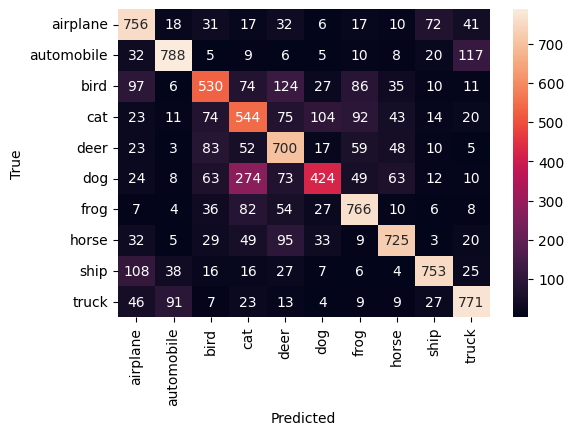

In [38]:
# Evaluate the gMLPImage model on the test dataset
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp, test_loader)

# Print the evaluation metrics
print(f"Test Accuracy: {test_accuracy:.2f}%\nTest Precision: {test_precision * 100:.2f}%\nTest Recall: {test_recall * 100:.2f}%")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusion

Despite the apparent simplicity of the overall gMLP architecture, fully understanding its intricacies required considerable time and numerous iterations of analysis. Existing implementations mentioned in the section below proved invaluable in clarifying specific details of the algorithm that might have been challenging to comprehend solely from the paper.

During testing, we encountered overfitting issues after approximately 8 epochs. To address this, we introduced dropout for the gMLP blocks, resulting in a slight improvement in results, although the impact was not substantial. Additional dropout mechanisms at different stages of the network and similar strategies could be explored as potential remedies against overfitting.

Through parameter adjustments, we successfully enhanced our results on datasets, initially yielding suboptimal numbers to more satisfactory outcomes in the end. Despite these improvements, there remains ample room for further refinement of the network. For instance, reevaluating image embeddings and employing data augmentation to augment dataset size could be beneficial. Additionally, running the network on more robust hardware and exploring other methods to mitigate overfitting are avenues worth exploring for future enhancements.

## References

References for Building this Notebook:

1. Paper: [Pay Attention to MLPs](https://arxiv.org/pdf/2105.08050v1.pdf)
2. [g-mlp-pytorch](https://github.com/lucidrains/g-mlp-pytorch)
3. [Pay-Attention-to-MLPs](https://github.com/antonyvigouret/Pay-Attention-to-MLPs)
4. [LabML](https://nn.labml.ai/transformers/gmlp/index.html)

These resources played a crucial role in informing our understanding and implementation of the gMLP architecture.